# Проект 5. Алгоритм кредитного скоринга

## Цель проекта
Написать скоринговую модель предсказания дефолта клиентов банка.

## Описание датасета
1. **client_id** - идентификатор клиента;
2. **education** - уровень образования;
3. **sex** - пол заёмщика;
4. **age** - возраст заёмщика;
5. **car** - флаг наличия автомобиля;
6. **car_type** - флаг автомобиля-иномарки;
7. **decline_app_cnt** - количество отказанных прошлых заявок;
8. **good_work** - флаг наличия «хорошей» работы;
9. **bki_request_cnt** - количество запросов в БКИ;
10. **home_address** - категоризатор домашнего адреса;
11. **work_address** - категоризатор рабочего адреса;
12. **income** - доход заёмщика;
13. **foreign_passport** - наличие загранпаспорта;
14. **sna** - связь заемщика с клиентами банка;
15. **first_time** - давность наличия информации о заемщике;
16. **score_bki** - скоринговый балл по данным из БКИ;
17. **region_rating** - рейтинг региона;
18. **app_date** - дата подачи заявки;
19. **default** - наличие дефолта.


**Целевая переменная** - "default"

## Задачи проекта
 1. Провести первичную обработку данных. Написать вспомогательные функции;
 2. Обнаружить и устранить выбросы для числовых переменных;
 3. Составить отчёт по результатам анализа данных.
 
## Этапы выполнения проекта
 1. **[Импорт библиотек и загрузка данных](#Импорт-библиотек-и-загрузка-данных)**
 2. **[Написание функций для обработки и анализа данных](#Функции-для-обработки-и-анализа-данных)**
 3. **[Обзор данных](#Обзор-данных)**

# Импорт библиотек и загрузка данных

In [201]:
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import pandas_profiling
from pandas import Series
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter('ignore')

In [296]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [297]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0

df = df_train.append(df_test, sort=False).reset_index(drop=True)

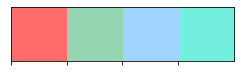

In [153]:
custom_colors = ["#ff6b6b", "#95d5b2", "#a2d2ff", "#72efdd"]
sns.palplot(sns.color_palette(custom_colors))

# Функции для обработки и анализа данных

In [48]:
def fill_na_values(column, data):
    '''Функция для заполнения пустых значений в зависимости от типа данных в столбце. 
    Если данные числовые, то пропуск будет заполнен медианой, 
    а остальные будут заполнены рандомно с учетом вероятности.
    '''
    if data.loc[:, column].dtypes == np.dtype('O'):
        values = data[column].value_counts()
        index = data[data[column].isna() == True].index
        new_value = pd.Series(random.choices(
            values.index, values, k=data[column].isna().sum()))
        new_value.index = index
        return data[column].fillna(new_value)
    else:
        return data[column].fillna(data[column].median())

In [49]:
def parsing_all_columns_data(data):
    '''Функция для анализа всех столбцов на количество 
    уникальных значений и количество пропусков'''
    
    for col in data.columns:
        unique_values = len(data[col].value_counts())
        empty_values = data[col].isna().sum()
        print(
            f"В столбце '{col}' уникальных значений = {unique_values} ,а количество пропусков = {empty_values}.")
        print(
            f'Процент пропусков = {round(empty_values*100/data.shape[0],1)}%')        

In [50]:
def definition_duplicates(data):
    '''Функция для определия дубликатов в датасете
    '''

    duplicate_data = data.duplicated().sum()
    if duplicate_data > 0:
        print('В датасете присутствуют дубликаты')
    else:
        print('В датасете дубликаты отсутствуют')

In [51]:
def display_iqr(column, data):
    '''Функция построения графиков для каждого столбца с определением границ для их данных.
    '''

    if data.loc[:, column].dtypes != np.dtype('O'):
        IQR = data[column].quantile(
            0.75) - data[column].quantile(0.25)
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        # Определим границы
        min_value, max_value = define_boundaries(data,column)
        data_out = data.loc[(~data.loc[:, column].between(
            min_value, max_value)) & (pd.notnull(data.loc[:, column]))]
        # Выведем полученные данные
        print_IQR(column, IQR, perc25, perc75,
                  min_value, max_value, data_out)

        data[column].loc[data[column].between(min_value, max_value)].hist(
            bins=10, range=(min_value, max_value), label='IQR')

        plt.legend()
        plt.show()

        display_data_out(data_out, column)

In [52]:
def define_boundaries(data,column):
    '''Функция определия границ выбросов 
    для определённой колонки(column) датасета
    '''

    IQR = data[column].quantile(
        0.75) - data[column].quantile(0.25)
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    min_value = perc25 - 1.5*IQR
    max_value = perc75 + 1.5*IQR

    return min_value, max_value

In [53]:
def display_data_out(data, column):
    '''Функция для отображения найденных выбросов
    '''

    if 0 < len(data) >= 5:
        print(f'Отображение первых 5 строк с ошибками в столбце {column}')
        display(data.head(5))
    elif len(data) == 1:
        print(f'Отображение строки с ошибкой в столбце {column}')
        display(data)

In [54]:
def print_IQR(column, IQR, perc25, perc75, min_value, max_value, data_out):
    '''Функция вывода данных'''

    print(f'Распределение IQR для столбца - {column}')
    print(f'Количество ошибок - {data_out.shape[0]}')
    print('25-й перцентиль: {},'.format(perc25),
          '75-й перцентиль: {},'.format(perc75),
          'IQR: {}, '.format(IQR),
          'Границы выбросов: [{}, {}].'.format(min_value, max_value))

In [12]:
def cols_to_drop(data):
    '''Функция для определия столбцов, 
    не влияющих на целевую переменную'''

    # Поиск колонок с большим количеством пропусков, более 90%
    many_null_cols = [
        col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    # Поиск колонок в которых одно из значений встречается > 95%
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(
        dropna=False, normalize=True).values[0] > 0.95]
    # Поиск колонок в которых только одно значение
    one_value_cols = [col for col in data.columns if data[col].nunique() <= 1]

    return list(set(many_null_cols + big_top_value_cols + one_value_cols))

# Обзор данных

In [256]:
# Проверка на успешность загрузки данных и краткий вывод таблицы с информацией
display(df.head())
df.info()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  sample  
0             2   18000    4           1                N        0       1  
1             3   19000    4           1                N        0       1  
2             2   30000    1           4                Y        0       1  
3             3   10000    1           3                N        0       1  
4             3   30000    1           4                Y        0       1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [257]:
# Вывод количества строк и столбцов таблицы
print(
    f'Датасет состоит из {df.shape[0]} строк и {df.shape[1]} столбцов')

Датасет состоит из 110148 строк и 20 столбцов


In [258]:
# Подсчёт уникальных значений и количество пропусков в столбцак датасета
parsing_all_columns_data(df)

В столбце 'client_id' уникальных значений = 110148 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'app_date' уникальных значений = 120 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'education' уникальных значений = 5 ,а количество пропусков = 478.
Процент пропусков = 0.4%
В столбце 'sex' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'age' уникальных значений = 52 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'car' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'car_type' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'decline_app_cnt' уникальных значений = 24 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'good_work' уникальных значений = 2 ,а количество пропусков = 0.
Процент пропусков = 0.0%
В столбце 'score_bki' уникальных значений = 102618 ,а количество пропусков = 0.
Процент пропусков = 0.0

In [259]:
definition_duplicates(df)

В датасете дубликаты отсутствуют


In [298]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# категориальные переменные
cat_cols = ['education', 'region_rating',
            'work_address', 'home_address','sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [18]:
pandas_profiling.ProfileReport(df)

# Обработка данных

## app_date


In [299]:
# преобразуем значение даты в dt формат
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [300]:
# посмотрим, за какой период представлены данные и можно ли их разделить по годам/сезонам/месяцам
df.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

In [301]:
# как видим, есть данные только за 4 месяца, поэтому формируем новый признак - месяц подачи заявки
df['app_month'] = df.app_date.dt.month

# Числовые переменные

## age

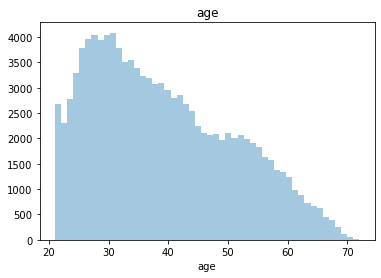

In [263]:
# построим график распределения признака
plt.figure()
sns.distplot(df['age'], kde=False,rug=False)
plt.title('age')
plt.show()

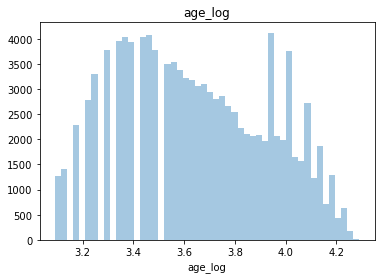

In [304]:
# у признака age тяжелый правый хвост, прологарифмируем его и построим новую гистограмму
df['age_log'] = df.age.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['age_log'][df['age_log'] > 0].dropna(), kde = False, rug=False)
plt.title('age_log')
plt.show()

In [265]:
df.age.describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

In [302]:
#разделим клиентов на 4 группы по возрасту, используя квартили
perc25 = np.percentile(df.age,25)
median = np.percentile(df.age,50)
perc75 = np.percentile(df.age,75)

def group_col(x, perc25,median,perc75):
    if x <= perc25:
        return 1
    elif perc25 < x <= median:
        return 2
    elif median < x <= perc75:
        return 3
    elif perc75 < x:
        return 4
    
df['group_of_age'] = df.age.apply(lambda x:group_col(x, perc25, median, perc75))

## decline_app_cnt

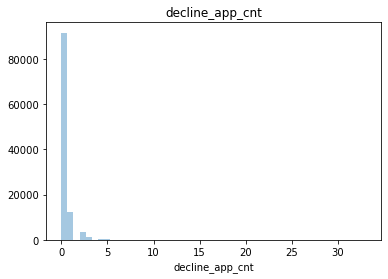

In [267]:
# построим график распределения признака
plt.figure()
sns.distplot(df['decline_app_cnt'], kde=False,rug=False)
plt.title('decline_app_cnt')
plt.show()

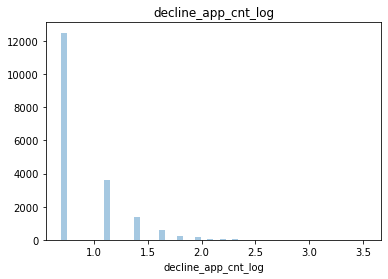

In [305]:
# у признака decline_app_cnt также тяжелый правый хвост, прологарифмируем его и построим новую гистограмму
df['decline_app_cnt_log'] = df.decline_app_cnt.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['decline_app_cnt_log'][df['decline_app_cnt_log'] > 0].dropna(), kde = False, rug=False)
plt.title('decline_app_cnt_log')
plt.show()

In [269]:
df.decline_app_cnt.describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [270]:
# есть выбросы. что с ними делать?
df.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

## bki_request_cnt

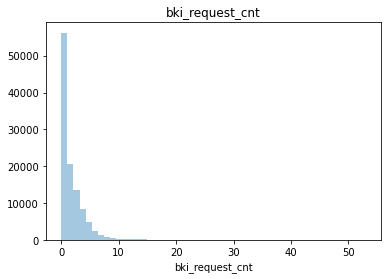

In [271]:
# построим график распределения признака
plt.figure()
sns.distplot(df['bki_request_cnt'], kde=False,rug=False)
plt.title('bki_request_cnt')
plt.show()

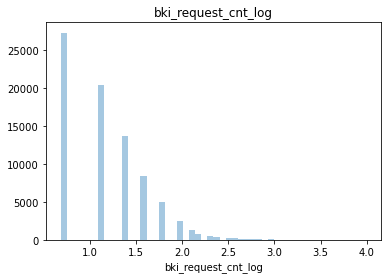

In [306]:
# как и у предыдущих признаков, у признака bki_request_cnt тяжелый правый хвост, прологарифмируем признак и построим новую гистограмму
df['bki_request_cnt_log'] = df.bki_request_cnt.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['bki_request_cnt_log'][df['bki_request_cnt_log'] > 0].dropna(), kde = False, rug=False)
plt.title('bki_request_cnt_log')
plt.show()

In [303]:
#если у клиента много запросов в БКИ, то скорее всего он часто обращается за кредитами и имеет долги
# введем доп переменную: 0 - если у клиента <3 запросов в БКИ и 1 - если >3
df['bki_cnt_many'] = df.bki_request_cnt.apply(lambda x:0 if x<3 else 1)

## income

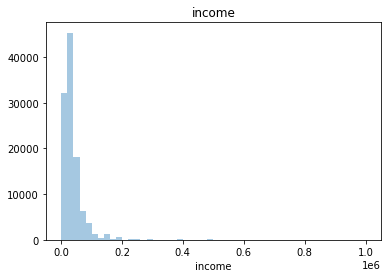

In [274]:
# построим график распределения признака
plt.figure()
sns.distplot(df['income'], kde=False,rug=False)
plt.title('income')
plt.show()

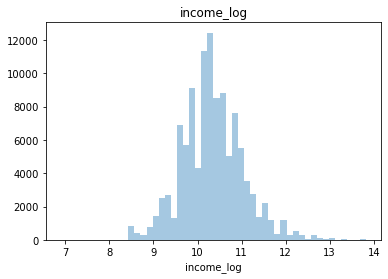

In [307]:
# как и у предыдущих признаков, у признака income тяжелый правый хвост, прологарифмируем признак и построим новую гистограмму
df['income_log'] = df.income.apply(lambda x: np.log(x + 1))

plt.figure()
sns.distplot(df['income_log'][df['income_log'] > 0].dropna(), kde = False, rug=False)
plt.title('income_log')
plt.show()

In [276]:
df.income.describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

In [308]:
#разделим клиентов на 4 группы по доходу, используя квартили
perc25 = np.percentile(df.income,25)
median = np.percentile(df.income,50)
perc75 = np.percentile(df.income,75)
    
df['group_of_income'] = df.income.apply(lambda x:group_col(x, perc25, median, perc75))

## score_bki

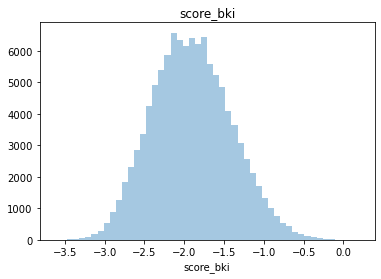

In [278]:
# построим график распределения признака
plt.figure()
sns.distplot(df['score_bki'], kde=False,rug=False)
plt.title('score_bki')
plt.show()

У данного признака распределение нормальное, в логарифмировании не нуждается

# Бинарные переменные

In [309]:
df[bin_cols]

sex car car_type foreign_passport  good_work
0        M   Y        Y                N          0
1        F   N        N                N          0
2        M   Y        N                Y          0
3        F   N        N                N          0
4        M   N        N                Y          1
...     ..  ..      ...              ...        ...
110143   F   N        N                N          0
110144   F   Y        Y                N          0
110145   M   N        N                N          0
110146   F   N        N                N          0
110147   M   N        N                N          0

[110148 rows x 5 columns]

In [310]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
df.head()    

client_id   app_date education  sex  age  car  car_type  decline_app_cnt  \
0      25905 2014-02-01       SCH    1   62    1         1                0   
1      63161 2014-03-12       SCH    0   59    0         0                0   
2      25887 2014-02-01       SCH    1   25    1         0                2   
3      16222 2014-01-23       SCH    0   53    0         0                0   
4     101655 2014-04-18       GRD    1   48    0         0                0   

   good_work  score_bki  ...  default  sample  app_month  group_of_age  \
0          0  -2.008753  ...        0       1          2             4   
1          0  -1.532276  ...        0       1          3             4   
2          0  -1.408142  ...        0       1          2             1   
3          0  -2.057471  ...        0       1          1             4   
4          1  -1.244723  ...        0       1          4             3   

   bki_cnt_many   age_log  decline_app_cnt_log  bki_request_cnt_log  \
0             0  4.143135             0.000000             0.693147   
1             1  4.094345             0.000000             1.386294   
2             0  3.258097             1.098612             0.693147   
3             0  3.988984             0.000000             1.098612   
4             0  3.891820             0.000000             0.693147   

   income_log  group_of_income  
0    9.798183                1  
1    9.852247                1  
2   10.308986                2  
3    9.210440                1  
4   10.308986                2  

[5 rows x 28 columns]

# Категориальные переменные

In [313]:
cat_cols = ['education', 'region_rating',
            'work_address', 'home_address','sna', 'first_time']

In [311]:
df['education'] = fill_na_values('education',df)

In [312]:
df['education'] = label_encoder.fit_transform(df['education'])  

# Значимость признаков

<AxesSubplot:>

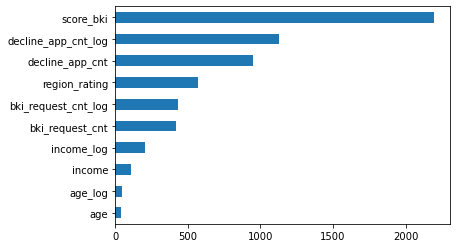

In [314]:
#оценим значимость числовых переменных c помощью функции f_classif 
num_cols = [
    'age',
    'age_log',
    'decline_app_cnt',
    'decline_app_cnt_log',
    'score_bki',
    'bki_request_cnt',
    'bki_request_cnt_log',
    'region_rating',
    'income',
    'income_log',
]
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [315]:
#как видим, логарифмированные переменные вносят больший вклад, оставим только их
num_cols = [
    'age_log',
    'decline_app_cnt_log',
    'score_bki',
    'bki_request_cnt_log',
    'region_rating',
    'income_log',
]

In [291]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample', 'app_month',
       'age_log', 'group_of_age', 'decline_app_cnt_log', 'bki_request_cnt_log',
       'bki_cnt_many', 'income_log', 'group_of_income'],
      dtype='object')

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            110148 non-null  int64         
 1   app_date             110148 non-null  datetime64[ns]
 2   education            110148 non-null  int64         
 3   sex                  110148 non-null  int64         
 4   age                  110148 non-null  int64         
 5   car                  110148 non-null  int64         
 6   car_type             110148 non-null  int64         
 7   decline_app_cnt      110148 non-null  int64         
 8   good_work            110148 non-null  int64         
 9   score_bki            110148 non-null  float64       
 10  bki_request_cnt      110148 non-null  int64         
 11  region_rating        110148 non-null  int64         
 12  home_address         110148 non-null  int64         
 13  work_address  

<AxesSubplot:>

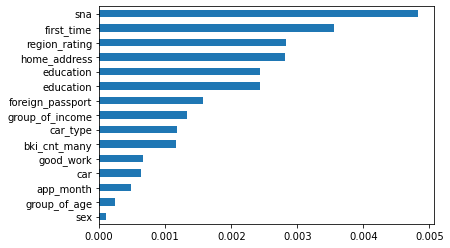

In [317]:
#оценим значимость категориальных и бинарных переменных c помощью функции mutual_info_classif 
cat_bin_cols = ['education', 'region_rating', 'home_address','sna', 'first_time',
                'sex', 'car', 'car_type', 'foreign_passport', 'good_work',
                'group_of_age', 'bki_cnt_many','education',
                'group_of_income','app_month']
imp_cat = Series(mutual_info_classif(df[cat_bin_cols], df['default'],
                                     discrete_features =True), index = cat_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [320]:
all_cols = num_cols + cat_bin_cols

In [319]:
#for column in num_cols:
    #display_iqr(column, df)

In [321]:
#cols_to_drop(df)

In [318]:
#применим OneHotEncoding к категориальным переменным
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

# Обучение модели

In [323]:
df_train

client_id   app_date  education  sex  age  car  car_type  \
0          25905 2014-02-01          3    1   62    1         1   
1          63161 2014-03-12          3    0   59    0         0   
2          25887 2014-02-01          3    1   25    1         0   
3          16222 2014-01-23          3    0   53    0         0   
4         101655 2014-04-18          1    1   48    0         0   
...          ...        ...        ...  ...  ...  ...       ...   
73794      54887 2014-03-04          1    0   45    0         0   
73795      76821 2014-03-24          3    1   41    1         1   
73796     103695 2014-04-22          3    1   31    0         0   
73797        861 2014-01-04          3    0   29    0         0   
73798      15796 2014-01-23          1    1   34    0         0   

       decline_app_cnt  good_work  score_bki  ...  foreign_passport  default  \
0                    0          0  -2.008753  ...                 0        0   
1                    0          0  -1.532276  ...                 0        0   
2                    2          0  -1.408142  ...                 1        0   
3                    0          0  -2.057471  ...                 0        0   
4                    0          1  -1.244723  ...                 1        0   
...                ...        ...        ...  ...               ...      ...   
73794                0          0  -1.792064  ...                 0        0   
73795                0          0  -2.058029  ...                 0        0   
73796                0          0  -1.512635  ...                 0        0   
73797                0          1  -1.479334  ...                 0        1   
73798                0          0  -1.764711  ...                 0        0   

       app_month  group_of_age  bki_cnt_many   age_log  decline_app_cnt_log  \
0              2             4             0  4.143135             0.000000   
1              3             4             1  4.094345             0.000000   
2              2             1             0  3.258097             1.098612   
3              1             4             0  3.988984             0.000000   
4              4             3             0  3.891820             0.000000   
...          ...           ...           ...       ...                  ...   
73794          3             3             1  3.828641             0.000000   
73795          3             3             0  3.737670             0.000000   
73796          4             2             1  3.465736             0.000000   
73797          1             1             1  3.401197             0.000000   
73798          1             2             0  3.555348             0.000000   

       bki_request_cnt_log  income_log  group_of_income  
0                 0.693147    9.798183                1  
1                 1.386294    9.852247                1  
2                 0.693147   10.308986                2  
3                 1.098612    9.210440                1  
4                 0.693147   10.308986                2  
...                    ...         ...              ...  
73794             1.386294    9.741027                1  
73795             0.693147   11.156265                4  
73796             1.609438   10.714440                3  
73797             1.386294    9.472782                1  
73798             1.098612   10.126671                2  

[73799 rows x 27 columns]

In [327]:
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_test = df.query('sample == 0').drop(['sample'], axis=1)

# разделяем выборки на тестовую и валидационную
X = df_train[all_cols]
y = df_train[['default']]
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False)

# Extract data for validation
X_test = df_test[all_cols]

# Проводим стандартизацию
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# обучаем модель и стром ROC кривую
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)


In [193]:
# Объединяем все переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную

#X = np.hstack([X_num, df[bin_cols].values, X_cat])
#Y = df['default'].values

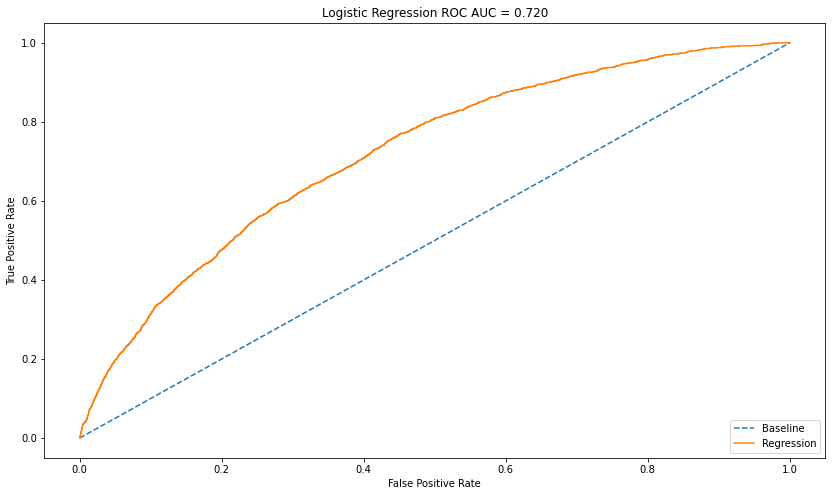

In [330]:
fpr, tpr, threshold = roc_curve(y_val,model.predict_proba(X_val)[:,1])
roc_auc = roc_auc_score(y_val,model.predict_proba(X_val)[:,1])

plt.figure(figsize=(14,8))
plt.plot([0,1],label='Baseline',linestyle='--')
plt.plot(fpr,tpr,label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [331]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [334]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

y_pred = model.predict(X_val)
f1_val = f1_score(y_val, y_pred)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[train] F1-score = 0.05
[valid] F1-score = 0.06
